In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
import numpy as np

In [2]:
# load data
data = pd.read_csv("./data/BTC-USD-1d.csv")

# data preprocessing

data['RSI'] = ta.rsi(data.Close, length=15)
data['EMAF'] = ta.ema(data.Close, length=10)
# data['EMAM'] = ta.ema(data['Close'], length=30)
# data['EMAS'] = ta.ema(data['Close'], length=50)
data.ta.bbands(close='Close', length=10, std=2, append=True)
pd.set_option("display.max_columns", None)

data['Target'] = data['Adj Close'] - data['Open']
data['Target'] = data['Target'].shift(-1)
data['TargetNextClose'] = data['Adj Close'].shift(-1)

# TODO clean
data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(['Date'], axis=1, inplace=True)
# data.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)
dataset = data.iloc[:, 0:len(data.columns)]

In [3]:
# data scaling 
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0,1))
dataset = sc.fit_transform(dataset)

dataset = pd.DataFrame(dataset)

In [4]:
dataset

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.000000,0.002923,0.002923,0.002534,0.003042,0.003074,0.000045,0.238627,0.002629,0.003210,0.002876,0.003025,0.223064,0.317602,0.507497,0.002692
1,0.000372,0.002692,0.002692,0.002420,0.002814,0.002943,0.000071,0.193218,0.002537,0.003140,0.002758,0.002866,0.208523,0.228500,0.506465,0.002237
2,0.000743,0.002237,0.002237,0.002227,0.002332,0.002716,0.000118,0.126671,0.002375,0.002852,0.002612,0.002848,0.262064,0.119093,0.507986,0.002113
3,0.001115,0.002113,0.002113,0.001897,0.001779,0.002256,0.000221,0.112140,0.002219,0.002586,0.002470,0.002819,0.312115,0.176628,0.509202,0.002255
4,0.001486,0.002255,0.002255,0.001945,0.001979,0.002130,0.000208,0.175169,0.002118,0.002463,0.002355,0.002713,0.319110,0.287013,0.508927,0.002346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2687,0.998514,0.655313,0.655313,0.649131,0.650372,0.651892,0.066218,0.630415,0.645818,0.576756,0.630930,0.670171,0.293228,0.718937,0.455928,0.643832
2688,0.998885,0.643832,0.643832,0.662742,0.652937,0.655619,0.091566,0.585689,0.651166,0.585848,0.638810,0.676856,0.286936,0.640105,0.430346,0.626660
2689,0.999257,0.626660,0.626660,0.635760,0.633480,0.644091,0.076786,0.524069,0.652264,0.596467,0.644493,0.678063,0.269106,0.546337,0.497267,0.624234
2690,0.999628,0.624234,0.624234,0.623828,0.629523,0.626891,0.051705,0.515658,0.652699,0.623711,0.652699,0.669206,0.205141,0.499173,0.505925,0.623538


In [5]:
# TODO feature engineering
backcandles = 10
X = []
for j in range(len(dataset.columns)):
    X.append([])
    for i in range(backcandles, len(dataset)):
        X[j].append(dataset.iloc[i - backcandles:i, j].values)

X = np.moveaxis(X, [0], [2])
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(dataset.iloc[backcandles:, -1].values, dtype=torch.float32).reshape(-1, 1)

In [6]:
# split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [7]:
# LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [8]:
# parameters
input_size = X.shape[2]
hidden_size = 150
num_layers = 1
num_epochs = 70
batch_size = 15
learning_rate = 0.0005

In [9]:
model = LSTMModel(input_size, hidden_size, num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [10]:
# train
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/70], Loss: 0.0015
Epoch [20/70], Loss: 0.0003
Epoch [30/70], Loss: 0.0003
Epoch [40/70], Loss: 0.0002
Epoch [50/70], Loss: 0.0001
Epoch [60/70], Loss: 0.0001
Epoch [70/70], Loss: 0.0001


In [11]:
# eval
model.eval()
with torch.no_grad():
    y_pred = model(X_test)


In [12]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.000000,0.002923,0.002923,0.002534,0.003042,0.003074,0.000045,0.238627,0.002629,0.003210,0.002876,0.003025,0.223064,0.317602,0.507497,0.002692
1,0.000372,0.002692,0.002692,0.002420,0.002814,0.002943,0.000071,0.193218,0.002537,0.003140,0.002758,0.002866,0.208523,0.228500,0.506465,0.002237
2,0.000743,0.002237,0.002237,0.002227,0.002332,0.002716,0.000118,0.126671,0.002375,0.002852,0.002612,0.002848,0.262064,0.119093,0.507986,0.002113
3,0.001115,0.002113,0.002113,0.001897,0.001779,0.002256,0.000221,0.112140,0.002219,0.002586,0.002470,0.002819,0.312115,0.176628,0.509202,0.002255
4,0.001486,0.002255,0.002255,0.001945,0.001979,0.002130,0.000208,0.175169,0.002118,0.002463,0.002355,0.002713,0.319110,0.287013,0.508927,0.002346


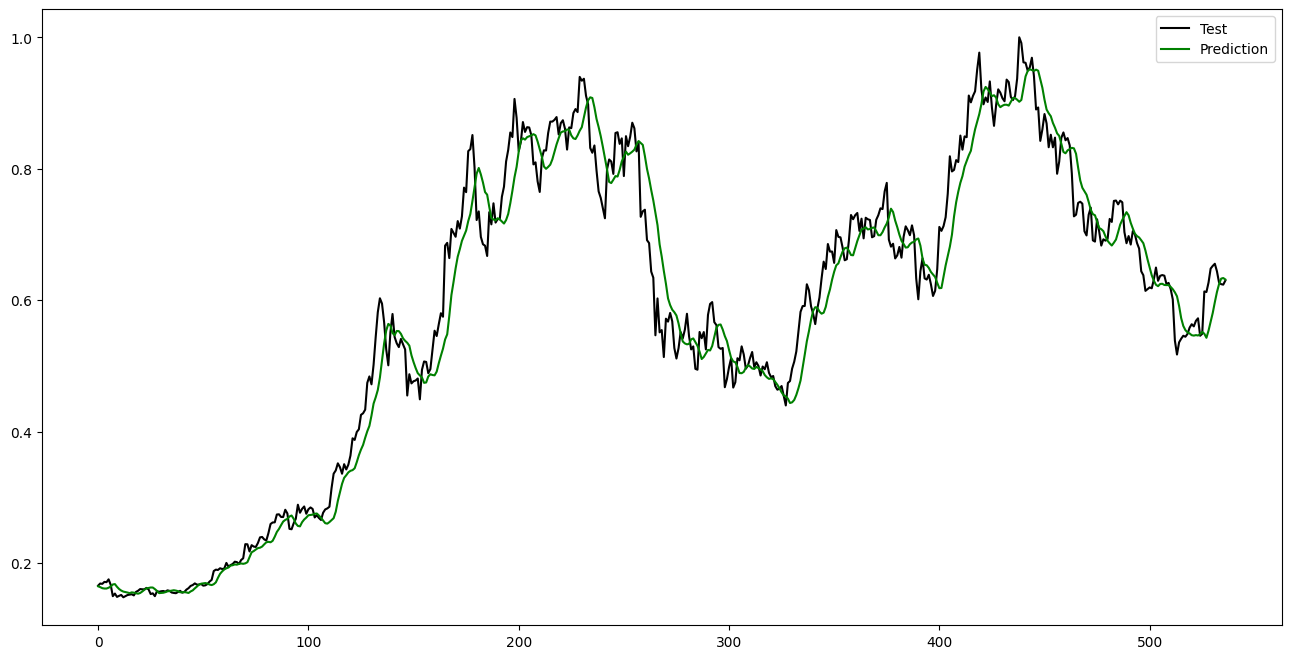

In [13]:
# plot
plt.figure(figsize=(16, 8))
plt.plot(y_test.numpy(), color='black', label='Test')
plt.plot(y_pred.numpy(), color='green', label='Prediction')
plt.legend()
plt.show()